Estimated total crack length: 0.00 pixels


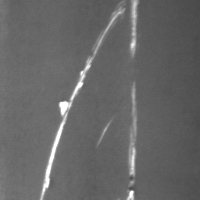

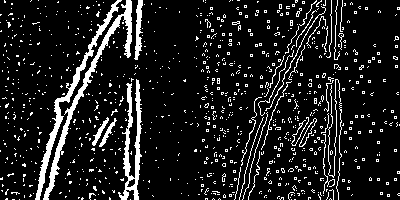

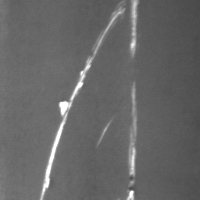

In [ ]:
#-------------------------------------------
# 1) Crack Detection on Metallic/Ceramic Surfaces
#-------------------------------------------
import cv2
import numpy as np
import argparse
from google.colab.patches import cv2_imshow # Import cv2_imshow

def detect_cracks(image_path, kernel_size=3, low_threshold=50, high_threshold=150):
    # Step 1: Load and preprocess
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Step 2: Adaptive thresholding for uneven lighting
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Step 3: Canny edge detection
    edges = cv2.Canny(binary, low_threshold, high_threshold, apertureSize=3)

    # Step 4: Morphological operations to connect and thin cracks
    kernel = np.ones((2, 2), np.uint8)  # Small kernel for thin cracks
    morphed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)  # Close gaps
    thinned = cv2.erode(morphed, kernel, iterations=1)  # Thin lines

    # Step 5: Find contours (cracks) and draw them
    contours, _ = cv2.findContours(thinned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = img.copy()
    for contour in contours:
        # Filter small noise contours (adjust area threshold as needed)
        if cv2.contourArea(contour) > 50:
            cv2.drawContours(output, [contour], -1, (0, 0, 255), 2)  # Red outline

    # Optional: Measure total crack length (perimeter of contours)
    total_length = sum(cv2.arcLength(c, True) for c in contours if cv2.contourArea(c) > 50)
    print(f"Estimated total crack length: {total_length:.2f} pixels")

    # Display results using cv2_imshow
    cv2_imshow(img)
    cv2_imshow(np.hstack((binary, edges)))
    cv2_imshow(output)
    # cv2.waitKey(0) is not needed with cv2_imshow
    # cv2.destroyAllWindows() is not needed with cv2_imshow

    return output

if __name__ == "__main__":
    image_to_process = '/content/crack.bmp'
    detect_cracks(image_to_process)

Attempting to resize defect_pcb to match reference_pcb.


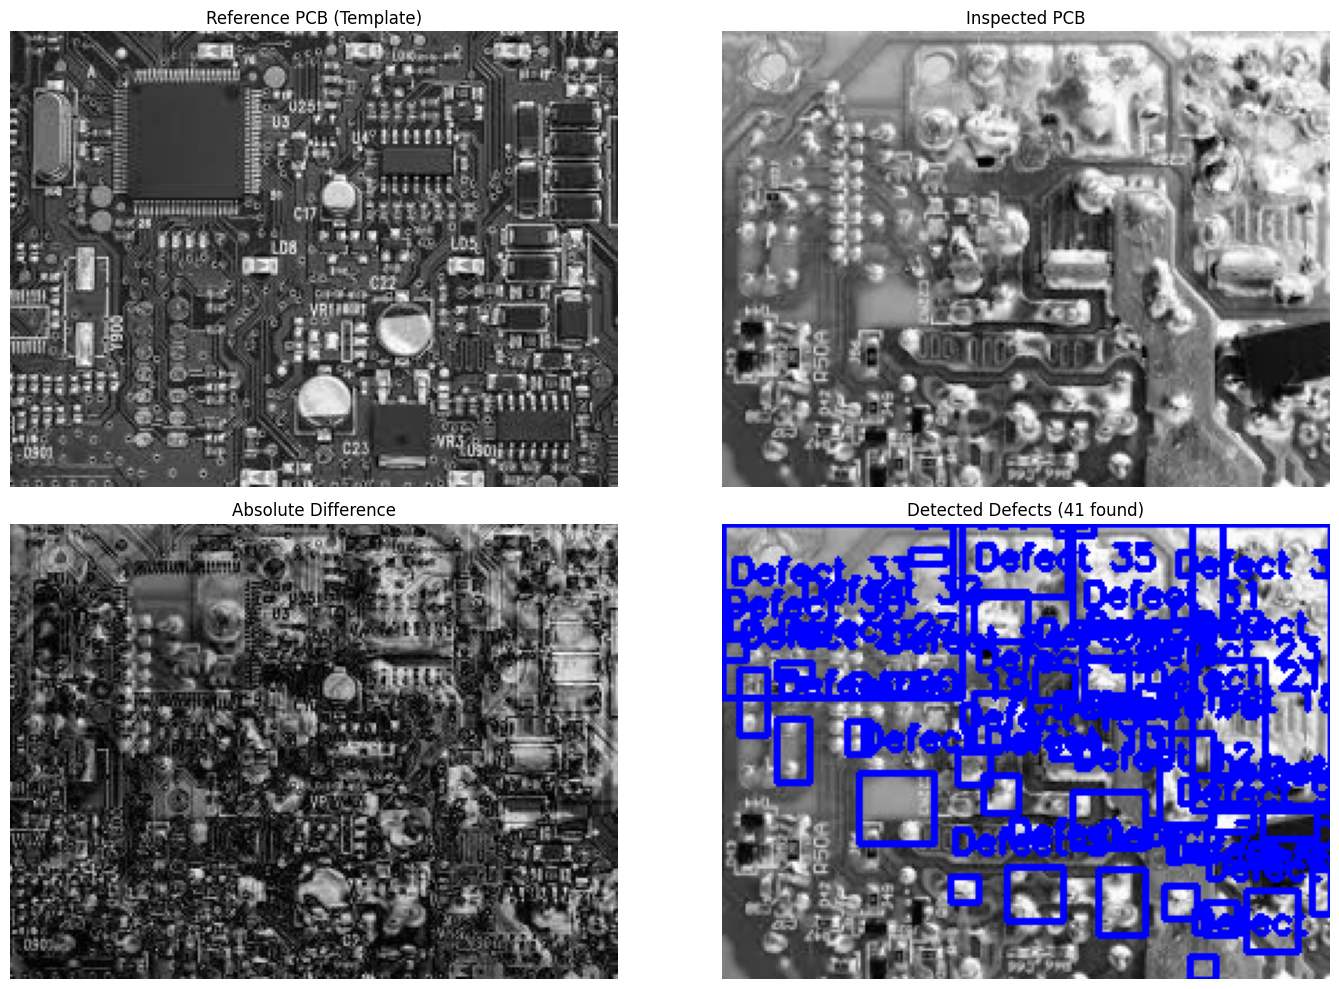


--- Inspection Summary ---
Total defects found: 41
Defects highlighted in blue rectangles on the inspected PCB image.


True

In [ ]:
#-------------------------------------------
# 2) PCB Inspection via Template Matching
#-------------------------------------------
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the reference (template) PCB image and the image to be inspected
# Make sure 'reference_pcb.png' is a known good PCB image
# Make sure 'defect_pcb.png' is the PCB image you want to inspect (could have defects)
try:
    reference_pcb = cv2.imread('reference_pcb.jpg', cv2.IMREAD_GRAYSCALE)
    defect_pcb = cv2.imread('defect_pcb.jpg', cv2.IMREAD_GRAYSCALE)
except Exception as e:
    print(f"Error loading images: {e}")
    print("Please ensure 'reference_pcb.png' and 'defect_pcb.png' are in the same directory.")
    # Create dummy images for demonstration if actual images are not found
    reference_pcb = np.zeros((300, 500), dtype=np.uint8)
    defect_pcb = np.zeros((300, 500), dtype=np.uint8)
    # Add some dummy features
    cv2.circle(reference_pcb, (150, 150), 50, 255, -1)
    cv2.rectangle(reference_pcb, (300, 100), (400, 200), 255, -1)
    cv2.circle(defect_pcb, (150, 150), 50, 255, -1)
    cv2.rectangle(defect_pcb, (300, 100), (400, 200), 255, -1)
    cv2.circle(defect_pcb, (350, 150), 10, 0, -1) # Introduce a "defect" in the dummy image


if reference_pcb is None or defect_pcb is None:
    print("Failed to load one or both images. Exiting.")
    exit()

# Ensure both images are the same size for direct comparison
# If they are not, you might need to register them or crop them appropriately
# For this example, we assume they are already aligned and of the same dimensions.
if reference_pcb.shape != defect_pcb.shape:
    print("Warning: Reference and defect PCB images have different dimensions.")
    print("Attempting to resize defect_pcb to match reference_pcb.")
    defect_pcb = cv2.resize(defect_pcb, (reference_pcb.shape[1], reference_pcb.shape[0]))


# --- Step 1: Image Alignment (if necessary) ---
# For robust template matching, images should be perfectly aligned.
# If there's slight rotation or translation, feature-based alignment (e.g., SIFT/ORB + homography)
# would be more appropriate. For simplicity, we assume rough alignment here.

# --- Step 2: Absolute Difference for Defect Detection ---
# Calculate the absolute difference between the reference and the inspected PCB
# Areas where the difference is significant likely indicate a defect.
difference = cv2.absdiff(reference_pcb, defect_pcb)

# --- Step 3: Thresholding the Difference Image ---
# Convert the difference image to a binary image to highlight defects
# Adjust the threshold value as needed. Higher values will detect larger differences.
_, thresholded_diff = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)

# --- Step 4: Morphological Operations (Optional but recommended) ---
# Use morphological operations to clean up the thresholded image
# - Dilation can help connect small fragmented defect regions.
# - Erosion can remove small noise spots.
kernel = np.ones((5, 5), np.uint8)
morphed_defects = cv2.morphologyEx(thresholded_diff, cv2.MORPH_OPEN, kernel) # Opening to remove noise

# --- Step 5: Finding and Drawing Contours of Defects ---
# Find contours in the morphed defects image
contours, _ = cv2.findContours(morphed_defects, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the defect_pcb to a color image to draw colored contours
defect_pcb_color = cv2.cvtColor(defect_pcb, cv2.COLOR_GRAY2BGR)

min_defect_area = 50 # Set a minimum area to filter out very small noise as defects

defect_count = 0
for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_defect_area:
        defect_count += 1
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(defect_pcb_color, (x, y), (x+w, y+h), (0, 0, 255), 2) # Draw red rectangle around defect
        cv2.putText(defect_pcb_color, f"Defect {defect_count}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


# --- Step 6: Visualization ---
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(reference_pcb, cmap='gray')
plt.title('Reference PCB (Template)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(defect_pcb, cmap='gray')
plt.title('Inspected PCB')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(difference, cmap='gray')
plt.title('Absolute Difference')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(defect_pcb_color)
plt.title(f'Detected Defects ({defect_count} found)')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n--- Inspection Summary ---")
print(f"Total defects found: {defect_count}")
if defect_count > 0:
    print("Defects highlighted in blue rectangles on the inspected PCB image.")
else:
    print("No significant defects detected based on the current threshold and area filters.")

cv2.imwrite('reference_pcb_output.png', reference_pcb)
cv2.imwrite('defect_pcb_output.png', defect_pcb_color)
cv2.imwrite('difference_output.png', difference)
cv2.imwrite('morphed_defects_output.png', morphed_defects)

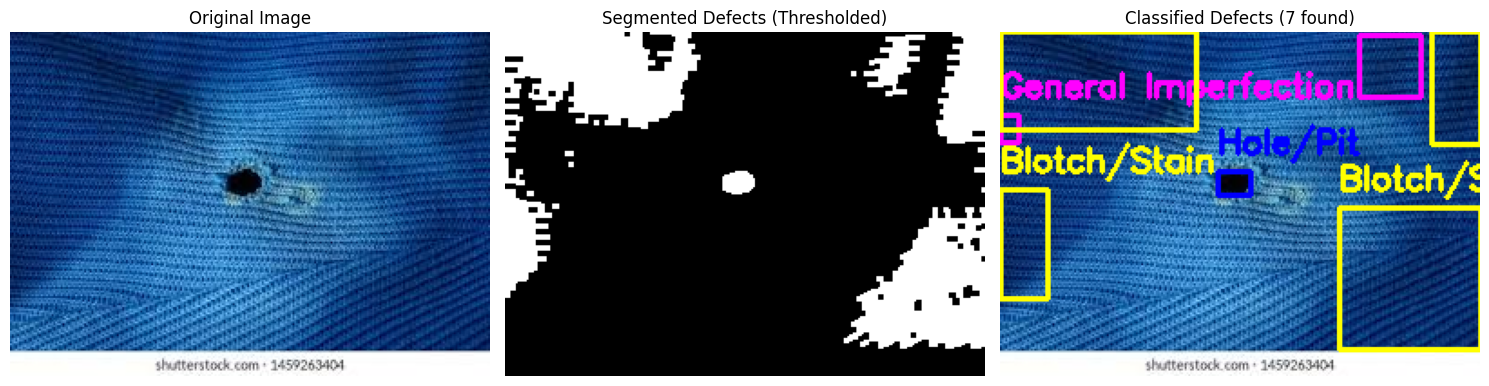


--- Defect Classification Summary ---
Defect 0: Type='Blotch/Stain', Area=3749.50, Aspect Ratio=1.00, Circularity=0.28
Defect 3: Type='Blotch/Stain', Area=866.00, Aspect Ratio=0.43, Circularity=0.24
Defect 5: Type='Hole/Pit', Area=169.00, Aspect Ratio=1.38, Circularity=0.82
Defect 13: Type='General Imperfection', Area=52.00, Aspect Ratio=0.67, Circularity=0.17
Defect 16: Type='General Imperfection', Area=425.00, Aspect Ratio=1.00, Circularity=0.12
Defect 17: Type='Blotch/Stain', Area=1147.00, Aspect Ratio=0.44, Circularity=0.26
Defect 18: Type='Blotch/Stain', Area=3868.00, Aspect Ratio=2.00, Circularity=0.15


In [4]:
#-------------------------------------------
# 3) Segment and Classify Defects (Rule Based)
#-------------------------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_synthetic_defect_image(width=600, height=400):
    """Creates a synthetic image with various 'surface defects' for demonstration."""
    img = np.full((height, width, 3), 200, dtype=np.uint8) # Light gray background

    # Defect 1: A scratch (elongated shape)
    cv2.line(img, (50, 100), (250, 120), (50, 50, 50), 3) # Darker line
    cv2.line(img, (50, 100), (250, 120), (0, 0, 0), 1) # Blacker core

    # Defect 2: A blotch/stain (irregular, larger area)
    cv2.ellipse(img, (350, 200), (70, 40), 30, 0, 360, (70, 70, 70), -1)
    cv2.circle(img, (380, 220), 20, (50, 50, 50), -1)

    # Defect 3: A small hole/dent (circular)
    cv2.circle(img, (150, 300), 15, (0, 0, 0), -1)

    # Defect 4: Another scratch (thinner, shorter)
    cv2.line(img, (400, 50), (480, 80), (0, 0, 0), 2)

    # Defect 5: Smaller blotch
    cv2.ellipse(img, (500, 350), (30, 20), 10, 0, 360, (70, 70, 70), -1)
    return img

def segment_and_classify_defects(image_path=None):
    if image_path:
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            print(f"Error: Could not load image from {image_path}. Using synthetic image.")
            img_bgr = create_synthetic_defect_image()
    else:
        print("No image path provided. Creating synthetic image for demonstration.")
        img_bgr = create_synthetic_defect_image()

    original_img = img_bgr.copy()
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # --- Preprocessing ---
    # Apply Gaussian blur to reduce noise
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Adaptive Thresholding for segmentation
    # This is more robust than simple global thresholding for varying lighting
    # We invert the threshold if defects are darker than background
    _, thresh = cv2.threshold(img_blur, 45, 255, cv2.THRESH_BINARY_INV)
    # If background is dark and defects are bright, use THRESH_BINARY + THRESH_OTSU

    # --- Morphological Operations to clean up segmentation ---
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) # Remove small noise
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1) # Close small gaps

    # --- Defect Segmentation: Find Contours ---
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_defects = []
    min_defect_area = 50 # Filter out very small contours (noise)

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        if area < min_defect_area:
            continue # Skip very small contours

        # --- Feature Extraction ---
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w)/h if h > 0 else 0
        extent = float(area)/(w*h) if (w*h) > 0 else 0 # Area of defect / area of bounding rectangle

        # Convex Hull and Solidity for irregular shapes
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area if hull_area > 0 else 0

        # Equivalent diameter and circularity for roundness
        equivalent_diameter = np.sqrt(4 * area / np.pi)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter**2) if perimeter > 0 else 0

        defect_type = "Unknown"
        color = (0, 0, 255) # Default red

        # --- Rule-Based Classification ---
        # Rule 1: Scratches (elongated, low circularity, high aspect ratio)
        if aspect_ratio > 2.5 and circularity < 0.6 and area < 500:
            defect_type = "Scratch"
            color = (0, 255, 0) # Green

        # Rule 2: Holes/Pits (more circular, smaller area)
        elif circularity > 0.7 and area < 1000 and extent > 0.6:
            defect_type = "Hole/Pit"
            color = (255, 0, 0) # Blue

        # Rule 3: Blotch/Stain (larger, irregular, moderate circularity/solidity)
        elif area > 500 and solidity > 0.7 and circularity < 0.7:
            defect_type = "Blotch/Stain"
            color = (0, 255, 255) # Yellow

        # Rule 4: General Imperfection (catch-all for others that are not noise)
        else:
            defect_type = "General Imperfection"
            color = (255, 0, 255) # Magenta


        detected_defects.append({
            "id": i,
            "type": defect_type,
            "bbox": (x, y, w, h),
            "area": area,
            "aspect_ratio": aspect_ratio,
            "circularity": circularity,
            "solidity": solidity,
            "color": color
        })

        # Draw bounding box and label
        cv2.rectangle(original_img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(original_img, defect_type, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # --- Visualization ---
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title('Segmented Defects (Thresholded)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Classified Defects ({len(detected_defects)} found)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\n--- Defect Classification Summary ---")
    if not detected_defects:
        print("No defects detected.")
    else:
        for defect in detected_defects:
            print(f"Defect {defect['id']}: Type='{defect['type']}', Area={defect['area']:.2f}, "
                  f"Aspect Ratio={defect['aspect_ratio']:.2f}, Circularity={defect['circularity']:.2f}")

segment_and_classify_defects('/content/cloth_pit.jpg')

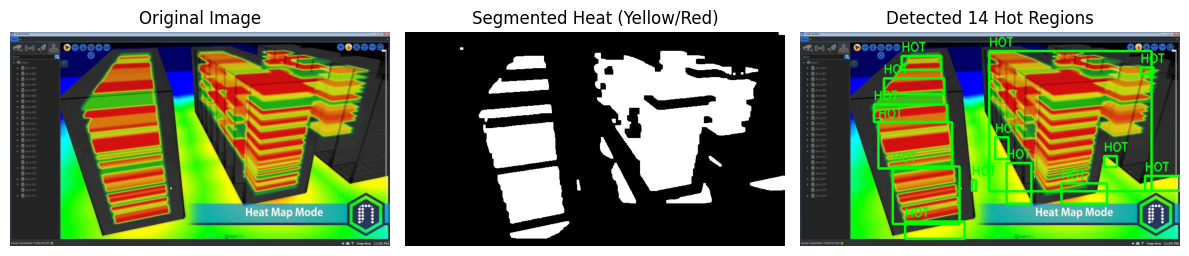

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_thermal_screenshot(image_path):
    # 1. Load as Original Color (NOT Grayscale)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error loading image.")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Convert to HSV Color Space
    # HSV allows us to separate "Color" (Hue) from "Brightness" (Value)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 3. Define Color Ranges for "HOT" (Yellow, Orange, Red)
    # Note: In OpenCV, Red wraps around 0 and 180.

    # Lower Red range (0-10)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])

    # Upper Red range (170-180)
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Yellow range (approx 20-35)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])

    # 4. Create Masks
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask3 = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Combine all "Hot" masks
    hot_spots_mask = mask1 | mask2 | mask3

    # 5. Morphological Cleanup (Remove small noise)
    kernel = np.ones((5, 5), np.uint8)
    hot_spots_mask = cv2.morphologyEx(hot_spots_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    hot_spots_mask = cv2.morphologyEx(hot_spots_mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # 6. Find Contours on the Mask
    contours, _ = cv2.findContours(hot_spots_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_img = img_rgb.copy()
    count = 0

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100: # Filter small dots
            count += 1
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_img, (x, y), (x+w, y+h), (0, 255, 0), 3) # Green Box
            cv2.putText(output_img, "HOT", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # --- Visualization ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hot_spots_mask, cmap='gray')
    plt.title("Segmented Heat (Yellow/Red)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(output_img)
    plt.title(f"Detected {count} Hot Regions")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the fixed function
analyze_thermal_screenshot('/content/ir_dc.jpg')